# SMS Spam Detection EDA

In [1]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from scipy.stats import ttest_ind_from_stats

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/smlovullo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/smlovullo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/smlovullo/nltk_data...


True

## Loading the Data

Import and display raw data from file

In [3]:
with open('../data/SMSSpamCollection.txt', 'r') as file_stream:
    sms_messages_raw = file_stream.readlines()

for message in sms_messages_raw:
    print(message, end='')

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

Collect labels for each message and check that the only labels in the file are 'ham' and 'spam'

In [4]:
labels = [re.search("(^.*)\t", message).group(1) for message in sms_messages_raw]
print(set(labels))

{'spam', 'ham'}


Check assumption that each message in the dataset ends with a new line character, then create a list of messages without labels and trailing new line characters

In [5]:
print(all(message.endswith('\n') for message in sms_messages_raw))

False


In [6]:
sms_messages = [message[message.index('\t')+1:-1] for message in sms_messages_raw]
print(sms_messages)

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They treat me like aids patent.', "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.', 'Had your mobile 

Stitch the data together in a data frame

In [7]:
messages_df = pd.DataFrame(data={'Labels': labels, 'Messages': sms_messages})
print(messages_df)

     Labels                                           Messages
0       ham  Go until jurong point, crazy.. Available only ...
1       ham                      Ok lar... Joking wif u oni...
2      spam  Free entry in 2 a wkly comp to win FA Cup fina...
3       ham  U dun say so early hor... U c already then say...
4       ham  Nah I don't think he goes to usf, he lives aro...
...     ...                                                ...
5569   spam  This is the 2nd time we have tried 2 contact u...
5570    ham               Will ü b going to esplanade fr home?
5571    ham  Pity, * was in mood for that. So...any other s...
5572    ham  The guy did some bitching but I acted like i'd...
5573    ham                          Rofl. Its true to its nam

[5574 rows x 2 columns]


## Exploratory Data Analysis

Check distribution of labels

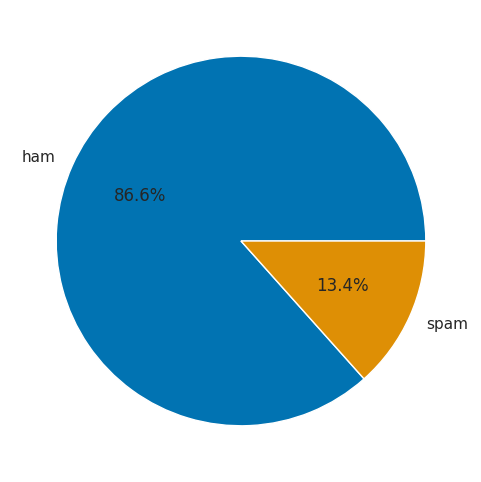

In [8]:
sns.set()
plt.figure(figsize=(6,6))
sns.set_palette("colorblind")
plt.pie(messages_df['Labels'].value_counts(), labels=messages_df['Labels'].unique(), autopct='%1.1f%%')
plt.show()

Checking distributions of various countable features (letters, words, punctuation, numeric characters, stopwords, upper/lower case characters)

In [9]:
def get_letter_count(s: str) -> int:
    count = 0
    for char in s:
        count += 1 if char.isalpha() else 0
    return count

def get_punc_count(s: str) -> int:
    count = 0
    for char in s:
        count += 1 if char in string.punctuation else 0
    return count

def get_numeric_count(s: str) -> int:
    count = 0
    tokens = word_tokenize(s)
    for word in tokens:
        count += 1 if word.isnumeric() else 0
    return count

def get_stopword_count(s: str) -> int:
    count = 0
    stop_words = set(stopwords.words())
    for char in s:
        count += 1 if char in stop_words else 0
    return count

def get_uppercase_count(s: str) -> int:
    count = 0
    for char in s:
        count += 1 if char.isupper() else 0
    return count

In [10]:
counts_dict = {
    'character_counts': [],
    'token_counts': [],
    'letter_counts': [],
    'punc_counts': [],
    'numeric_counts': [],
    'stopword_counts': [],
    'uppercase_counts': []
}
for message in messages_df['Messages']:
    counts_dict['character_counts'].append(len(message))
    counts_dict['token_counts'].append(len(word_tokenize(message)))
    counts_dict['letter_counts'].append(get_letter_count(message))
    counts_dict['punc_counts'].append(get_punc_count(message))
    counts_dict['numeric_counts'].append(get_numeric_count(message))
    counts_dict['stopword_counts'].append(get_stopword_count(message))
    counts_dict['uppercase_counts'].append(get_uppercase_count(message))

In [11]:
messages_df = messages_df.join(pd.DataFrame(counts_dict))

In [12]:
messages_df

,Labels,Messages,character_counts,token_counts,letter_counts,punc_counts,numeric_counts,stopword_counts,uppercase_counts
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,83,9,0,62,3
1,ham,Ok lar... Joking wif u oni...,29,8,18,6,0,12,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,97,6,3,72,10
3,ham,U dun say so early hor... U c already then say...,49,13,33,6,0,28,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,47,2,0,40,2
...,...,...,...,...,...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,160,35,101,8,3,83,9
5570,ham,Will ü b going to esplanade fr home?,36,9,28,1,0,21,1
5571,ham,"Pity, * was in mood for that. So...any other s...",57,15,41,7,0,33,2
5572,ham,The guy did some bitching but I acted like i'd...,125,27,99,1,0,81,2


### Character Counts

In [13]:
custom_color_palette = ["#BF0000", "#00C864", "#00AFFF"]

All messages

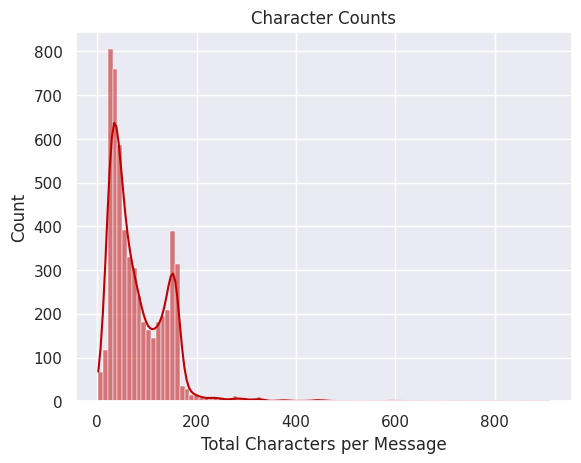

In [14]:
sns.histplot(messages_df['character_counts'], kde=True, color=custom_color_palette[0])
plt.title('Character Counts')
plt.xlabel('Total Characters per Message')
plt.ylabel('Count')
plt.show()

In [15]:
messages_df['character_counts'].quantile(0.99)

276.0

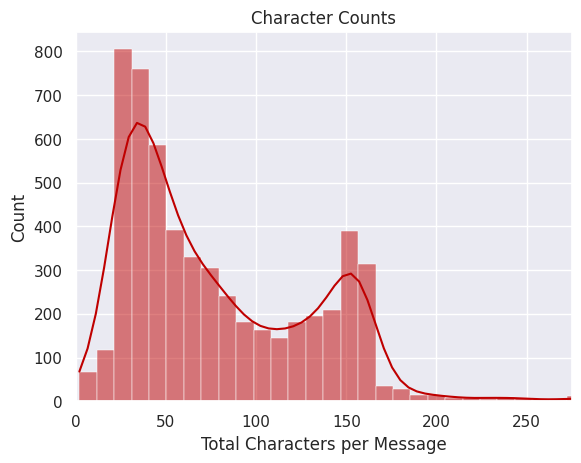

In [16]:
sns.histplot(messages_df['character_counts'], kde=True, color=custom_color_palette[0])
plt.title('Character Counts')
plt.xlabel('Total Characters per Message')
plt.ylabel('Count')
plt.xlim(0,275)
plt.show()

Nonspam Messages

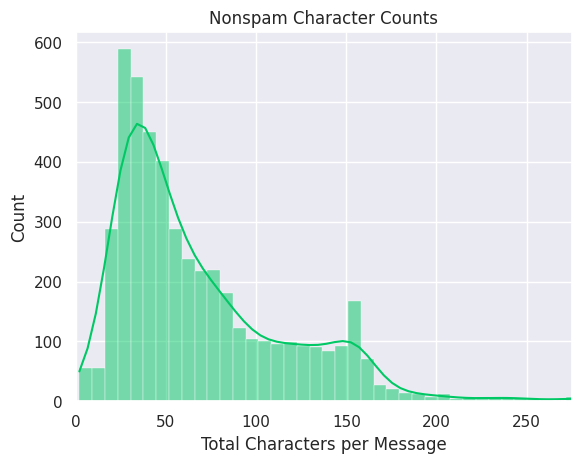

In [17]:
sns.histplot(messages_df[messages_df['Labels'] == 'ham']['character_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Character Counts')
plt.xlabel('Total Characters per Message')
plt.ylabel('Count')
plt.xlim(0,275)
plt.show()

Spam Messages

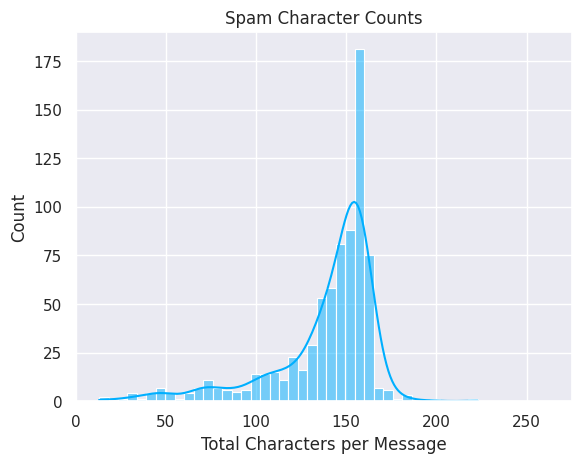

In [18]:
sns.histplot(messages_df[messages_df['Labels'] == 'spam']['character_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Character Counts')
plt.xlabel('Total Characters per Message')
plt.ylabel('Count')
plt.xlim(0,275)
plt.show()

Visually, we can see that there is a local maximum on all three graphs when the value on the horizontal axis is 150; in other words, there is a notable subset of messages that tend to be around 150 characters in length. However, this local maximum is small when looking at only the nonspam messages and is relatively larger when looking at the spam messages (in fact, this chracter length is maximum of the estimated density function shown with the spam histogram). The spam messages do not have many low-character messages among its subset, while it is much more common among the nonspam messages.

### Word Counts

All messages

In [19]:
messages_df['token_counts'].quantile(0.99)

67.26999999999953

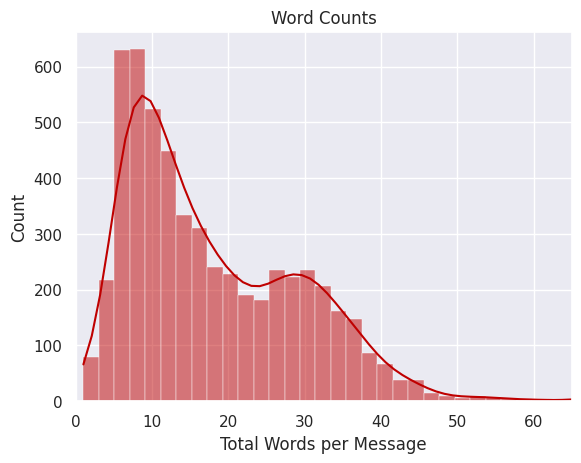

In [20]:
sns.histplot(messages_df['token_counts'], kde=True, color=custom_color_palette[0])
plt.title('Word Counts')
plt.xlabel('Total Words per Message')
plt.ylabel('Count')
plt.xlim(0,65)
plt.show()

Nonspam Messages

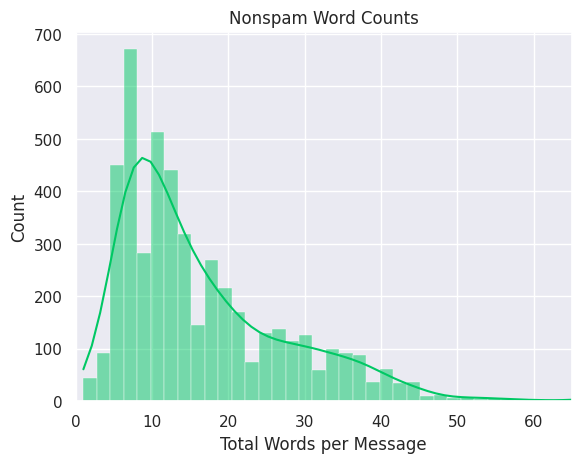

In [21]:
sns.histplot(messages_df[messages_df['Labels'] == 'ham']['token_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Word Counts')
plt.xlabel('Total Words per Message')
plt.ylabel('Count')
plt.xlim(0,65)
plt.show()

Spam Messages

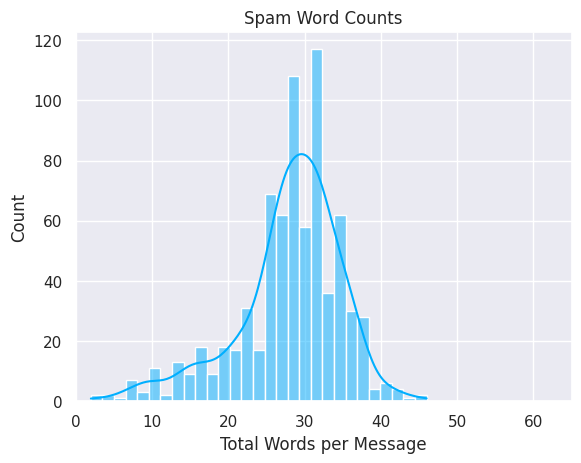

In [22]:
sns.histplot(messages_df[messages_df['Labels'] == 'spam']['token_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Word Counts')
plt.xlabel('Total Words per Message')
plt.ylabel('Count')
plt.xlim(0,65)
plt.show()

The word counts show the same kind of pattern as described regarding the character counts

### Letter Counts

All messages

In [23]:
messages_df['letter_counts'].quantile(0.99)

205.0

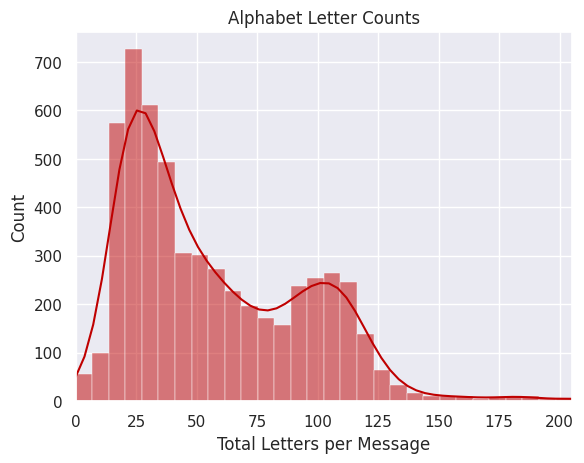

In [24]:
sns.histplot(messages_df['letter_counts'], kde=True, color=custom_color_palette[0])
plt.title('Alphabet Letter Counts')
plt.xlabel('Total Letters per Message')
plt.ylabel('Count')
plt.xlim(0,205)
plt.show()

Nonspam Messages

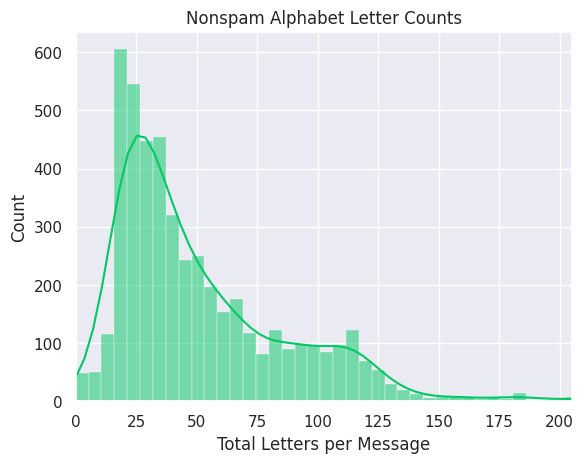

In [25]:
sns.histplot(messages_df[messages_df['Labels'] == 'ham']['letter_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Alphabet Letter Counts')
plt.xlabel('Total Letters per Message')
plt.ylabel('Count')
plt.xlim(0,205)
plt.show()

Spam Messages

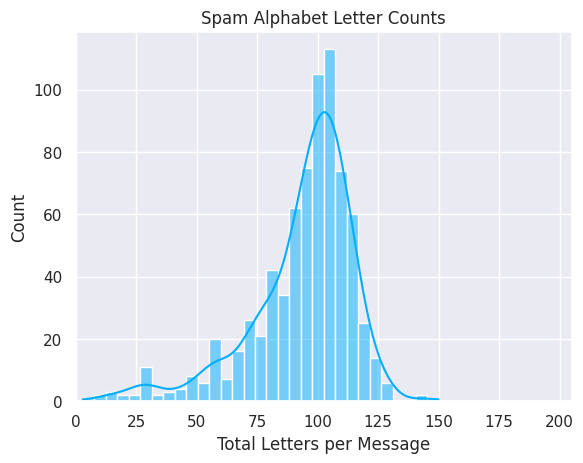

In [26]:
sns.histplot(messages_df[messages_df['Labels'] == 'spam']['letter_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Alphabet Letter Counts')
plt.xlabel('Total Letters per Message')
plt.ylabel('Count')
plt.xlim(0,205)
plt.show()

The letter counts show the same kind of pattern as described regarding the character and word counts

### Punctuation Counts

All messages

In [27]:
messages_df['punc_counts'].quantile(0.99)

19.269999999999527

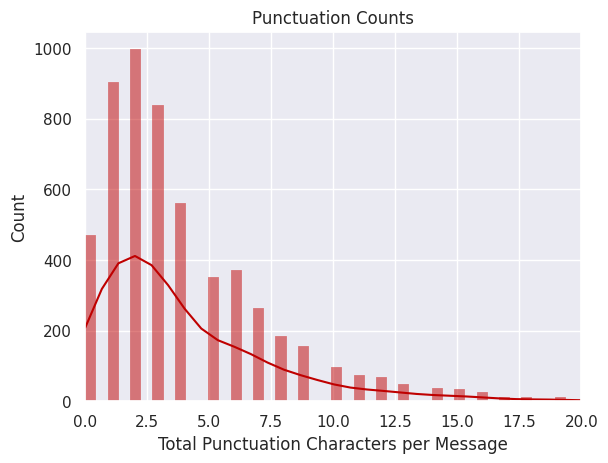

In [28]:
sns.histplot(messages_df['punc_counts'], kde=True, color=custom_color_palette[0])
plt.title('Punctuation Counts')
plt.xlabel('Total Punctuation Characters per Message')
plt.ylabel('Count')
plt.xlim(0,20)
plt.show()

Nonspam Messages

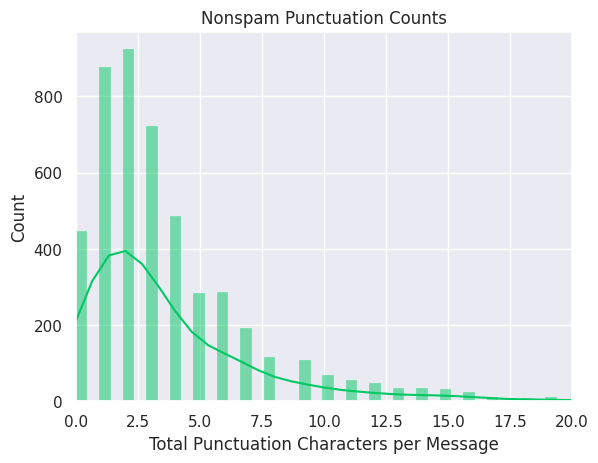

In [29]:
sns.histplot(messages_df[messages_df['Labels'] == 'ham']['punc_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Punctuation Counts')
plt.xlabel('Total Punctuation Characters per Message')
plt.ylabel('Count')
plt.xlim(0,20)
plt.show()

Spam Messages

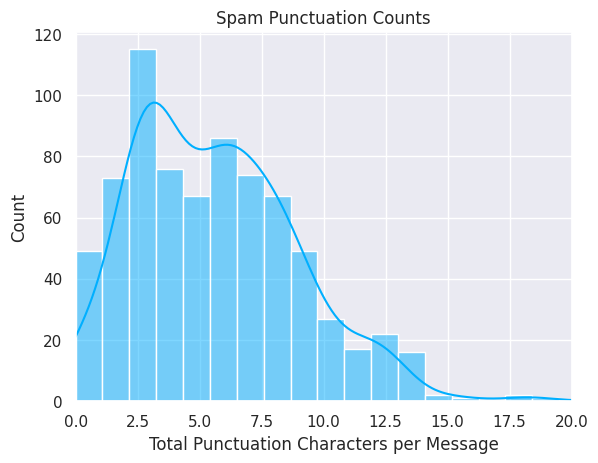

In [30]:
sns.histplot(messages_df[messages_df['Labels'] == 'spam']['punc_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Punctuation Counts')
plt.xlabel('Total Punctuation Characters per Message')
plt.ylabel('Count')
plt.xlim(0,20)
plt.show()

There is some notable visual difference between the nonspam and spam plots, but that is likely due to the difference in sample sizes. The spam messages only account for roughly 13.4% of the data set (which is 747 out of the total of 5574 messages, compared to the 4827 nonspam messages)

To compare the two samples, the average punctuation counts for each will be bootstrapped and have their means compared using a hypothesis test comaring the difference between the two means (t-test)

In [31]:
nonspam_punc_counts = np.array(messages_df[messages_df['Labels'] == 'ham']['punc_counts'])
spam_punc_counts = np.array(messages_df[messages_df['Labels'] == 'spam']['punc_counts'])

mean1 = bs.bootstrap(nonspam_punc_counts, stat_func=bs_stats.mean).value
std1 = bs.bootstrap(nonspam_punc_counts, stat_func=bs_stats.std).value
mean2 = bs.bootstrap(spam_punc_counts, stat_func=bs_stats.mean).value
std2 = bs.bootstrap(spam_punc_counts, stat_func=bs_stats.std).value

print(f"Bootstrap mean for punctutation counts of nonspam messages: {mean1}")
print(f"Bootstrap standard deviation for punctutation counts of nonspam messages: {std1}")
print(f"Bootstrap mean for punctutation counts of spam messages: {mean2}")
print(f"Bootstrap standard deviation for punctutation counts of spam messages: {std2}")

Bootstrap mean for punctutation counts of nonspam messages: 3.9593950694012845
Bootstrap standard deviation for punctutation counts of nonspam messages: 4.7365226776121325
Bootstrap mean for punctutation counts of spam messages: 5.717536813922356
Bootstrap standard deviation for punctutation counts of spam messages: 3.458958117025729


In [32]:
t_stat, p_val = ttest_ind_from_stats(
    mean1, std1, len(nonspam_punc_counts),
    mean2, std2, len(spam_punc_counts)
)

print(f"t-statistic for difference between means : {t_stat}")
print(f"p-value for difference between means {p_val}:")

t-statistic for difference between means : -9.750351830657774
p-value for difference between means 2.768270304592209e-22:


Based on the results of the bootstrapping and t-test, there is a difference between the punctuation counts of the spam and nonspam messages, with spam messages typically having more punctuation than nonspam messages.

### Number Counts

All messages

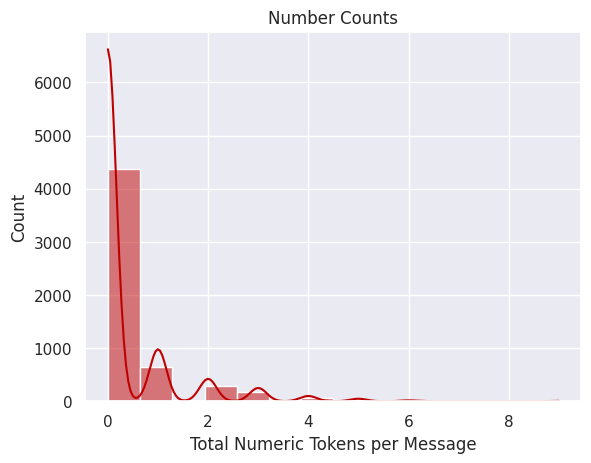

In [33]:
sns.histplot(messages_df['numeric_counts'], kde=True, color=custom_color_palette[0])
plt.title('Number Counts')
plt.xlabel('Total Numeric Tokens per Message')
plt.ylabel('Count')
plt.show()

The majority of all messages do not contain any numbers. Instead, let's consider the total number count for messages that contain 1 or more numeric characters.

In [34]:
has_numbers_df = messages_df.query("numeric_counts > 0")

print(f'There are {has_numbers_df.shape[0]} messages that have numeric tokens')
print(f'These messages account for roughly {round(100*has_numbers_df.shape[0]/messages_df.shape[0],1)}% of the total number of messages ({messages_df.shape[0]} messages)')

There are 1202 messages that have numeric tokens
These messages account for roughly 21.6% of the total number of messages (5574 messages)


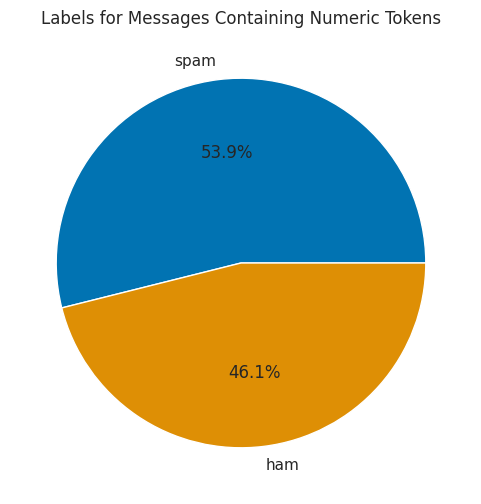

In [35]:
sns.set()
plt.figure(figsize=(6,6))
sns.set_palette("colorblind")
plt.pie(has_numbers_df['Labels'].value_counts(), labels=has_numbers_df['Labels'].unique(), autopct='%1.1f%%')
plt.title('Labels for Messages Containing Numeric Tokens')
plt.show()

In this subset of the data containing numeric characters, the distribution of labels is nearly even, making direct comparisons of the plots between nonspam and spam groups reasonable

In [36]:
has_numbers_df['numeric_counts'].quantile(0.99)

6.0

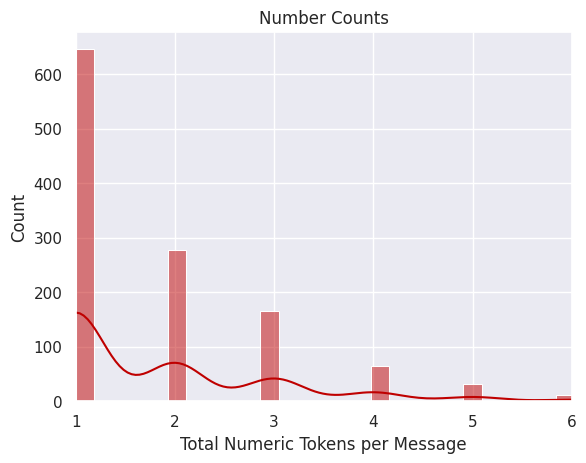

In [37]:
sns.histplot(has_numbers_df['numeric_counts'], kde=True, color=custom_color_palette[0])
plt.title('Number Counts')
plt.xlabel('Total Numeric Tokens per Message')
plt.ylabel('Count')
plt.xlim(1,6)
plt.show()

Nonspam Messages

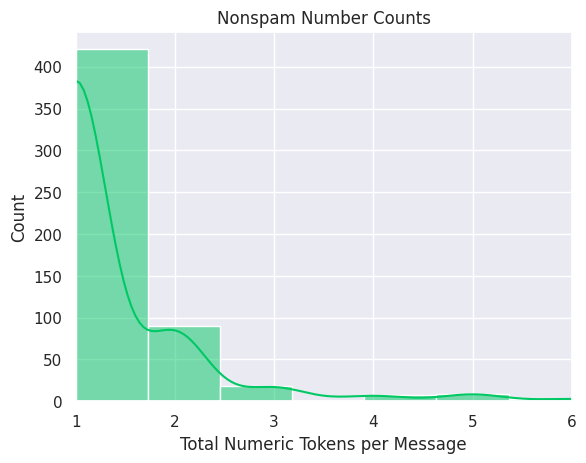

In [38]:
sns.histplot(has_numbers_df[has_numbers_df['Labels'] == 'ham']['numeric_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Number Counts')
plt.xlabel('Total Numeric Tokens per Message')
plt.ylabel('Count')
plt.xlim(1,6)
plt.show()

Spam Messages

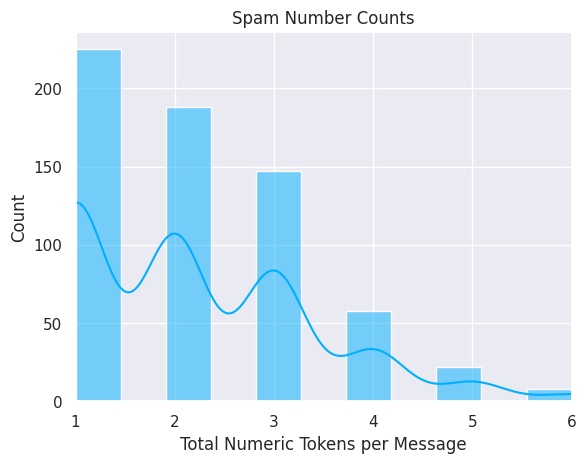

In [39]:
sns.histplot(has_numbers_df[has_numbers_df['Labels'] == 'spam']['numeric_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Number Counts')
plt.xlabel('Total Numeric Tokens per Message')
plt.ylabel('Count')
plt.xlim(1,6)
plt.show()

Of the messages that do contain numbers, spam messages typically contain a higher number of numeric tokens than nonspam messages

### Stopword Counts

All messages

In [40]:
messages_df['stopword_counts'].quantile(0.99)

161.8899999999967

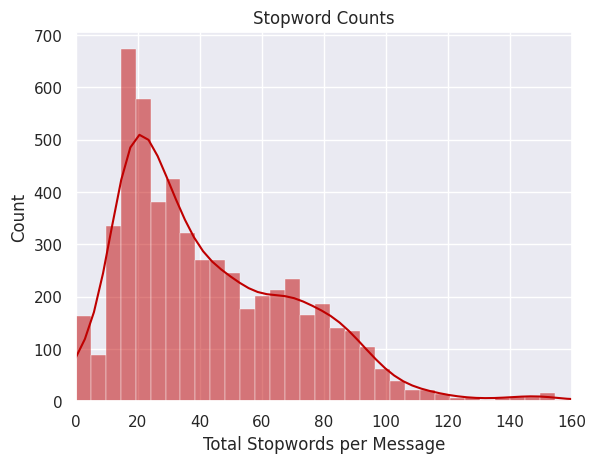

In [41]:
sns.histplot(messages_df['stopword_counts'], kde=True, color=custom_color_palette[0])
plt.title('Stopword Counts')
plt.xlabel('Total Stopwords per Message')
plt.ylabel('Count')
plt.xlim(0,160)
plt.show()

Nonspam Messages

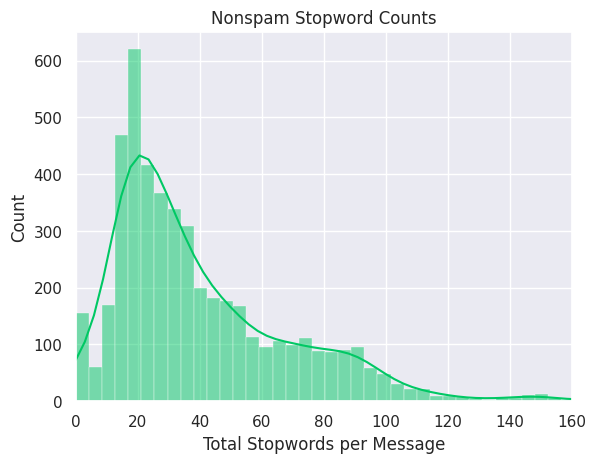

In [42]:
sns.histplot(messages_df[messages_df['Labels'] == 'ham']['stopword_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Stopword Counts')
plt.xlabel('Total Stopwords per Message')
plt.ylabel('Count')
plt.xlim(0,160)
plt.show()

Spam Messages

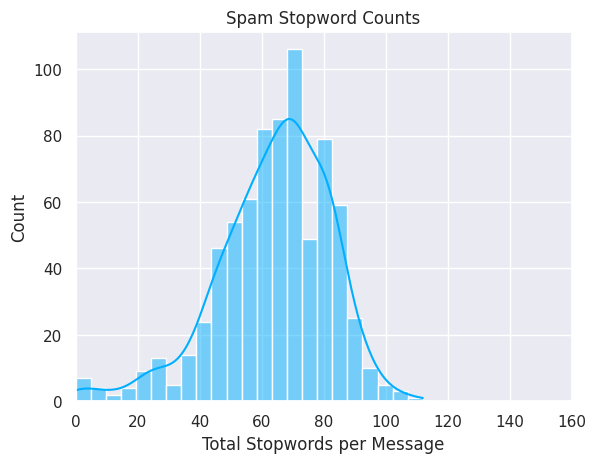

In [43]:
sns.histplot(messages_df[messages_df['Labels'] == 'spam']['stopword_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Stopword Counts')
plt.xlabel('Total Stopwords per Message')
plt.ylabel('Count')
plt.xlim(0,160)
plt.show()

The histograms show that spam messages often contain more stop words than nonspam messages

### Uppercase Counts

All messages

In [44]:
messages_df['uppercase_counts'].quantile(0.99)

62.539999999999054

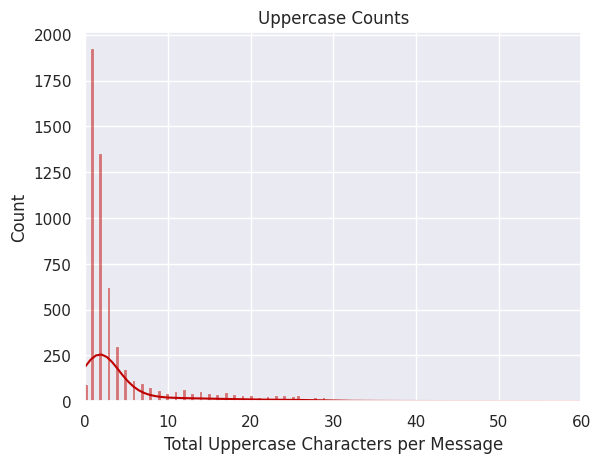

In [45]:
sns.histplot(messages_df['uppercase_counts'], kde=True, color=custom_color_palette[0])
plt.title('Uppercase Counts')
plt.xlabel('Total Uppercase Characters per Message')
plt.ylabel('Count')
plt.xlim(0,60)
plt.show()

Nonspam Messages

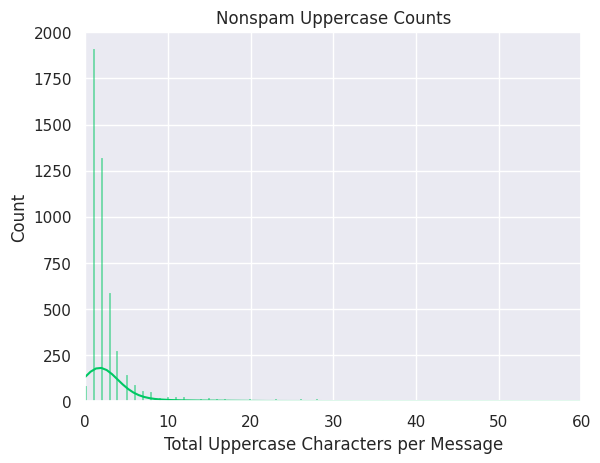

In [46]:
sns.histplot(messages_df[messages_df['Labels'] == 'ham']['uppercase_counts'], kde=True, color=custom_color_palette[1])
plt.title('Nonspam Uppercase Counts')
plt.xlabel('Total Uppercase Characters per Message')
plt.ylabel('Count')
plt.xlim(0,60)
plt.show()

Spam Messages

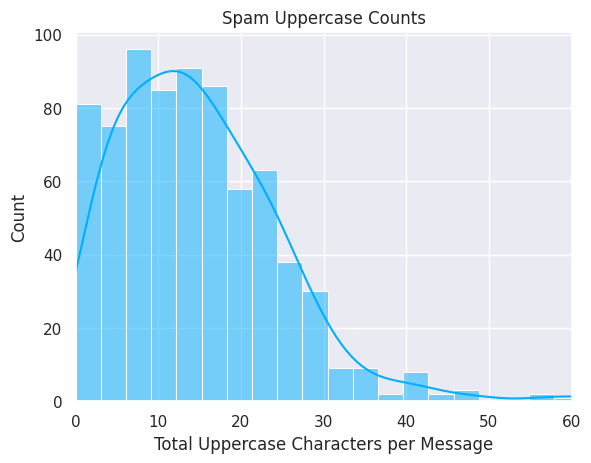

In [47]:
sns.histplot(messages_df[messages_df['Labels'] == 'spam']['uppercase_counts'], kde=True, color=custom_color_palette[2])
plt.title('Spam Uppercase Counts')
plt.xlabel('Total Uppercase Characters per Message')
plt.ylabel('Count')
plt.xlim(0,60)
plt.show()

In [48]:
nonspam_uppercase_counts = np.array(messages_df[messages_df['Labels'] == 'ham']['uppercase_counts'])
spam_uppercase_counts = np.array(messages_df[messages_df['Labels'] == 'spam']['uppercase_counts'])

mean1 = bs.bootstrap(nonspam_uppercase_counts, stat_func=bs_stats.mean).value
std1 = bs.bootstrap(nonspam_uppercase_counts, stat_func=bs_stats.std).value
mean2 = bs.bootstrap(spam_uppercase_counts, stat_func=bs_stats.mean).value
std2 = bs.bootstrap(spam_uppercase_counts, stat_func=bs_stats.std).value

print(f"Bootstrap mean for uppercase counts of nonspam messages: {mean1}")
print(f"Bootstrap standard deviation for uppercase counts of nonspam messages: {std1}")
print(f"Bootstrap mean for uppercase counts of spam messages: {mean2}")
print(f"Bootstrap standard deviation for uppercase counts of spam messages: {std2}")

Bootstrap mean for uppercase counts of nonspam messages: 4.1087632069608455
Bootstrap standard deviation for uppercase counts of nonspam messages: 10.807426906752559
Bootstrap mean for uppercase counts of spam messages: 15.46987951807229
Bootstrap standard deviation for uppercase counts of spam messages: 12.297520580803404


In [49]:
t_stat, p_val = ttest_ind_from_stats(
    mean1, std1, len(nonspam_uppercase_counts),
    mean2, std2, len(spam_uppercase_counts)
)

print(f"t-statistic for difference between means : {t_stat}")
print(f"p-value for difference between means {p_val}:")

t-statistic for difference between means : -26.224633658155664
p-value for difference between means 4.904818250608701e-143:


Based on the results of the t-test, it can be concluded that spam messages typically have more uppercase characters than nonspam messages

### Correlations

In [50]:
counts_df = messages_df.drop(labels=['Messages'], axis=1)
counts_df['Labels'] = counts_df['Labels'].apply(lambda x: 1 if x == 'spam' else 0)
counts_df

,Labels,character_counts,token_counts,letter_counts,punc_counts,numeric_counts,stopword_counts,uppercase_counts
0,0,111,24,83,9,0,62,3
1,0,29,8,18,6,0,12,2
2,1,155,37,97,6,3,72,10
3,0,49,13,33,6,0,28,2
4,0,61,15,47,2,0,40,2
...,...,...,...,...,...,...,...,...
5569,1,160,35,101,8,3,83,9
5570,0,36,9,28,1,0,21,1
5571,0,57,15,41,7,0,33,2
5572,0,125,27,99,1,0,81,2


In [51]:
counts_df.drop(['Labels'], axis=1).corr()

,character_counts,token_counts,letter_counts,punc_counts,numeric_counts,stopword_counts,uppercase_counts
character_counts,1.000000,0.966369,0.990789,0.642950,0.377943,0.939872,0.381440
token_counts,0.966369,1.000000,0.950648,0.733292,0.328721,0.909273,0.347314
letter_counts,0.990789,0.950648,1.000000,0.590507,0.300563,0.958301,0.356146
punc_counts,0.642950,0.733292,0.590507,1.000000,0.220052,0.550606,0.255478
numeric_counts,0.377943,0.328721,0.300563,0.220052,1.000000,0.213950,0.318897
stopword_counts,0.939872,0.909273,0.958301,0.550606,0.213950,1.000000,0.084968
uppercase_counts,0.381440,0.347314,0.356146,0.255478,0.318897,0.084968,1.000000


In [52]:
counts_df.drop(labels=['Labels','token_counts','letter_counts','stopword_counts'], axis=1).corr()

,character_counts,punc_counts,numeric_counts,uppercase_counts
character_counts,1.000000,0.642950,0.377943,0.381440
punc_counts,0.642950,1.000000,0.220052,0.255478
numeric_counts,0.377943,0.220052,1.000000,0.318897
uppercase_counts,0.381440,0.255478,0.318897,1.000000


In [53]:
features_df = counts_df.drop(labels=['token_counts','letter_counts','stopword_counts'], axis=1)
features_df

,Labels,character_counts,punc_counts,numeric_counts,uppercase_counts
0,0,111,9,0,3
1,0,29,6,0,2
2,1,155,6,3,10
3,0,49,6,0,2
4,0,61,2,0,2
...,...,...,...,...,...
5569,1,160,8,3,9
5570,0,36,1,0,1
5571,0,57,7,0,2
5572,0,125,1,0,2


In [54]:
print(f"Number of possible outliers in character_counts: {features_df[features_df['character_counts'] > features_df['character_counts'].quantile(0.99)].shape[0]}")
print(f"Number of possible outliers in character_counts: {features_df[features_df['punc_counts'] > features_df['punc_counts'].quantile(0.99)].shape[0]}")
print(f"Number of possible outliers in character_counts: {features_df[features_df['numeric_counts'] > features_df['numeric_counts'].quantile(0.99)].shape[0]}")
print(f"Number of possible outliers in character_counts: {features_df[features_df['uppercase_counts'] > features_df['uppercase_counts'].quantile(0.99)].shape[0]}")

Number of possible outliers in character_counts: 55
Number of possible outliers in character_counts: 56
Number of possible outliers in character_counts: 48
Number of possible outliers in character_counts: 56


In [55]:
indices_with_outliars = set()
for index in features_df[features_df['character_counts'] > features_df['character_counts'].quantile(0.99)].index.to_list():
    indices_with_outliars.add(index)
for index in features_df[features_df['punc_counts'] > features_df['punc_counts'].quantile(0.99)].index.to_list():
    indices_with_outliars.add(index)
for index in features_df[features_df['numeric_counts'] > features_df['numeric_counts'].quantile(0.99)].index.to_list():
    indices_with_outliars.add(index)
for index in features_df[features_df['uppercase_counts'] > features_df['uppercase_counts'].quantile(0.99)].index.to_list():
    indices_with_outliars.add(index)
indices_with_outliars = list(indices_with_outliars)
print(f"There are {len(indices_with_outliars)} rows containing outliers")

There are 183 rows containing outliers


### Word Content

In [56]:
text_df = messages_df[['Labels','Messages']]
text_df

,Labels,Messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [57]:
class TextCleaner():

    def __init__(self):
        self.punct_table = str.maketrans('', '', string.punctuation)
        self.stopwords = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.transformations = [
            self._strip_punct,
            self._convert_to_lowercase,
            self._remove_stopwords,
            self._remove_numbers,
            self._remove_special_characters,
            self._lemmatize
        ]

    def fit(self, X, y):
        return self

    def fit_transform(self, X, y):
        return self.clean_text(X)

    def transform(self, X):
        return self.clean_text(X)

    def clean_text(self, X):
        cleaned_text = []
        for text in X:
            for transformation in self.transformations:
                text = transformation(text)
            cleaned_text.append(text)
        return cleaned_text

    def _strip_punct(self, text: str) -> str:
        return text.translate(self.punct_table)

    def _convert_to_lowercase(self, text: str) -> str:
        return text.lower()

    def _remove_stopwords(self, text: str) -> str:
        words = nltk.word_tokenize(text)
        words = [w for w in words if w not in self.stopwords]
        return ' '.join(words)

    def _remove_numbers(self, text: str) -> str:
        words = nltk.word_tokenize(text)
        words = [w for w in words if not re.search(r'\d', w)]
        return ' '.join(words)

    def _remove_special_characters(self, text: str) -> str:
        pattern = r'[^a-zA-Z0-9\s]'
        return re.sub(pattern, '', text)

    def _lemmatize(self, text: str) -> str:
        words = nltk.word_tokenize(text)
        words = [self.lemmatizer.lemmatize(w) for w in words]
        return ' '.join(words)

In [58]:
text_pipe = Pipeline([
    ('text_cleaner', TextCleaner()),
    ('vectorizer', CountVectorizer())
])

In [59]:
word_counts = text_pipe.fit_transform(text_df['Messages']).toarray()
word_counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
vocab = text_pipe.named_steps['vectorizer'].get_feature_names_out()
vocab

array(['aa', 'aah', 'aaniye', ..., 'zoom', 'zouk', 'zyada'], dtype=object)

In [61]:
word_counts_df = text_df[['Labels']].join(pd.DataFrame(data=word_counts, columns=vocab))
word_counts_df

,Labels,aa,aah,aaniye,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5571,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
nonspam_word_counts = word_counts_df[word_counts_df['Labels'] == 'ham'].drop(labels=['Labels'], axis=1)
nonspam_word_counts

,aa,aah,aaniye,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,abeg,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
spam_word_counts = word_counts_df[word_counts_df['Labels'] == 'spam'].drop(labels=['Labels'], axis=1)
spam_word_counts

,aa,aah,aaniye,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,abeg,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
word_counts_df = word_counts_df.drop(labels=['Labels'], axis=1)

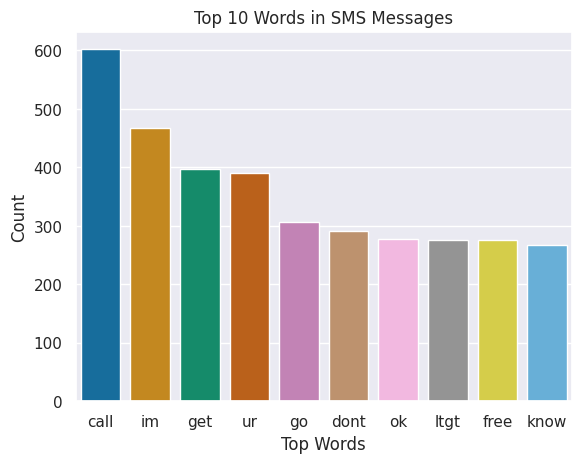

In [65]:
all_top_words = pd.DataFrame(word_counts_df.sum(), columns=['count']).sort_values(by='count', ascending=False).head(10)

sns.barplot(x=all_top_words.index, y=all_top_words['count'])
plt.xlabel('Top Words')
plt.ylabel('Count')
plt.title('Top 10 Words in SMS Messages')
plt.show()

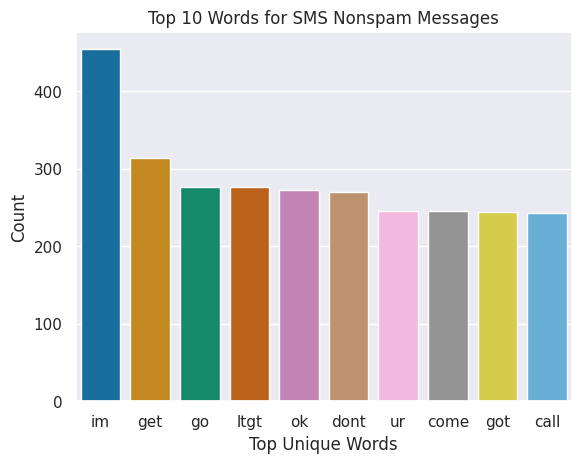

In [66]:
nonspam_top_words = pd.DataFrame(nonspam_word_counts.sum(), columns=['count']).sort_values(by='count', ascending=False).head(10)

sns.barplot(x=nonspam_top_words.index, y=nonspam_top_words['count'])
plt.xlabel('Top Unique Words')
plt.ylabel('Count')
plt.title('Top 10 Words for SMS Nonspam Messages')
plt.show()

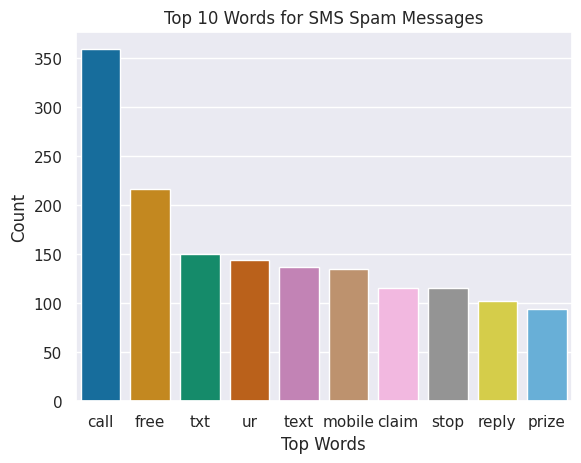

In [67]:
spam_top_words = pd.DataFrame(spam_word_counts.sum(), columns=['count']).sort_values(by='count', ascending=False).head(10)

sns.barplot(x=spam_top_words.index, y=spam_top_words['count'])
plt.xlabel('Top Words')
plt.ylabel('Count')
plt.title('Top 10 Words for SMS Spam Messages')
plt.show()